<a href="https://colab.research.google.com/github/subir7/tfproject/blob/main/LDA_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy -qq
!python -m spacy download en_core_web_md -qq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
!pip uninstall numpy
!pip install numpy==1.23.1

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 41.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.1 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; pyth

In [1]:
# Common data handling libraries
import os
import string
import pandas as pd
import numpy as np
import glob
import pickle

# Gensim for LDA
import gensim

# NLTK for test processing
import nltk
nltk.download('stopwords')

# spacy for Lemmatization
import spacy

# Visualization
import matplotlib.pyplot as plt

# Deep learning modeling
import tensorflow as tf

# Model evaluation metrics
import sklearn
import pathlib
import collections

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
print("Numpy version is: ", np.__version__)
print("Pandas version is: ", pd.__version__)
print("Tensorflow version is: ", tf.__version__)

Numpy version is:  1.23.1
Pandas version is:  2.0.3
Tensorflow version is:  2.15.0


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
def get_data(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)


In [5]:
def get_dataset(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')
    captions = (path/'Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    train_imgs_path = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path/'Flickr_8k.testImages.txt').read_text().splitlines()

    train_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
    test_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

    return train_caps[:1000], test_caps[:100]

In [6]:
get_data()
train_raw, test_raw = get_dataset()

2340801/2340801 [==============================] - 0s 0us/step


In [7]:
#print(train_raw)
train_image_list = []
train_caption_list = []

test_image_list = []
test_caption_list = []

for raw in train_raw:
    #store it in list
    train_image_list.append(raw[0])
    train_caption_list.append(' '.join(raw[1]))

for raw in test_raw:
    #store it in list
    test_image_list.append(raw[0])
    test_caption_list.append(' '.join(raw[1]))

In [8]:
len(train_image_list), len(train_caption_list), len(test_image_list), len(test_caption_list)

(1000, 1000, 100, 100)

In [9]:
train_df = pd.DataFrame({'image_id':train_image_list, 'caption':train_caption_list})
train_df = train_df.groupby('image_id')['caption'].apply(lambda x : ' '.join(x)).reset_index(name='caption')

test_df = pd.DataFrame({'image_id':test_image_list, 'caption':test_caption_list})
test_df = test_df.groupby('image_id')['caption'].apply(lambda x : ' '.join(x)).reset_index(name='caption')

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

train_df.head()

,image_id,caption
0,flickr8k/Flicker8k_Dataset/1012212859_01547e3f17.jpg,"A dog shakes its head near the shore , a red ball next to it . A white dog shakes on the edge of a beach with an orange ball . Dog with orange ball at feet , stands on shore shaking off water White dog playing with a red ball on the shore near the water . White dog with brown ears standing near water with head turned to one side ."
1,flickr8k/Flicker8k_Dataset/101669240_b2d3e7f17b.jpg,A man in a hat is displaying pictures next to a skier in a blue hat . A man skis past another man displaying paintings in the snow . A person wearing skis looking at framed pictures set up in the snow . A skier looks at framed pictures in the snow next to trees . Man on skis looking at artwork for sale in the snow
2,flickr8k/Flicker8k_Dataset/1019604187_d087bf9a5f.jpg,A dog prepares to catch a thrown object in a field with nearby cars . A white dog is about to catch a yellow ball in its mouth . A white dog is about to catch a yellow dog toy . A white dog is ready to catch a yellow ball flying through the air . A white dog running after a yellow ball
3,flickr8k/Flicker8k_Dataset/103205630_682ca7285b.jpg,"A tent is being set up on the ice . Two men are about to enter an ice fishing tent on a snow covered lake . two men setting up a blue ice fishing hut on an iced over lake Two men , standing on an ice , looking into something covered with a blue tarp . Two people standing outside a blue tent structure on a snowy surface ."
4,flickr8k/Flicker8k_Dataset/1052358063_eae6744153.jpg,A boy takes a jump on his skateboard while another boy with a skateboard watches . A child is performing a skateboard trick while another child with a skateboard leans on a wall . A little boy skateboarder is doing a trick on his board while another young skateboarder watches . a young boy skateboarder jumping on a platform on a skateboard . Two skateboarders .


In [11]:
train_df['caption'][0]

'A dog shakes its head near the shore , a red ball next to it . A white dog shakes on the edge of a beach with an orange ball . Dog with orange ball at feet , stands on shore shaking off water White dog playing with a red ball on the shore near the water . White dog with brown ears standing near water with head turned to one side .'

In [12]:
def clean_text(data):

    # convert to lower case
    data = [word.lower() for word in data.split()]

    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    # remove punctuation from each word
    data = [word.translate(table) for word in data]

    # remove tokens with numbers in them
    data = [word for word in data if word.isalpha()]

    # remove stopwords
    data = [word for word in data if word not in nltk.corpus.stopwords.words('english')]

    return data

In [13]:
train_data_caption = list(train_df['caption'].apply(lambda x : clean_text(x)))
test_data_caption = list(test_df['caption'].apply(lambda x : clean_text(x)))
#train_data_caption[:5]

In [14]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
train_caption_lemmatized = [[word.lemma_ for word in nlp(str(' '.join(doc))) if word.pos_ in allowed_postags]
                           for doc in train_data_caption]
test_caption_lemmatized = [[word.lemma_ for word in nlp(str(' '.join(doc))) if word.pos_ in allowed_postags]
                           for doc in test_data_caption]
#train_caption_lemmatized[:5]

In [15]:
train_df['caption_lemmatized'] = train_caption_lemmatized
test_df['caption_lemmatized'] = test_caption_lemmatized
train_df.head()

,image_id,caption,caption_lemmatized
0,flickr8k/Flicker8k_Dataset/1012212859_01547e3f17.jpg,"A dog shakes its head near the shore , a red ball next to it . A white dog shakes on the edge of a beach with an orange ball . Dog with orange ball at feet , stands on shore shaking off water White dog playing with a red ball on the shore near the water . White dog with brown ears standing near water with head turned to one side .","[dog, shake, head, shore, ball, next, white, dog, shake, edge, foot, stand, shore, shake, water, white, dog, play, red, ball, shore, water, white, dog, brown, ear, stand, water, head, turn, side]"
1,flickr8k/Flicker8k_Dataset/101669240_b2d3e7f17b.jpg,A man in a hat is displaying pictures next to a skier in a blue hat . A man skis past another man displaying paintings in the snow . A person wearing skis looking at framed pictures set up in the snow . A skier looks at framed pictures in the snow next to trees . Man on skis looking at artwork for sale in the snow,"[man, hat, display, picture, skier, blue, hat, man, ski, man, display, painting, snow, person, wear, ski, look, framed, picture, set, snow, skier, look, framed, picture, snow, next, tree, man, ski, look, artwork, sale, snow]"
2,flickr8k/Flicker8k_Dataset/1019604187_d087bf9a5f.jpg,A dog prepares to catch a thrown object in a field with nearby cars . A white dog is about to catch a yellow ball in its mouth . A white dog is about to catch a yellow dog toy . A white dog is ready to catch a yellow ball flying through the air . A white dog running after a yellow ball,"[dog, prepare, catch, throw, object, field, nearby, car, white, catch, yellow, ball, mouth, catch, yellow, dog, toy, ready, catch, yellow, ball, fly, air, white, dog, run, yellow, ball]"
3,flickr8k/Flicker8k_Dataset/103205630_682ca7285b.jpg,"A tent is being set up on the ice . Two men are about to enter an ice fishing tent on a snow covered lake . two men setting up a blue ice fishing hut on an iced over lake Two men , standing on an ice , looking into something covered with a blue tarp . Two people standing outside a blue tent structure on a snowy surface .","[tent, set, ice, man, enter, ice, fishing, tent, snow, cover, lake, man, set, blue, ice, fishing, lake, man, stand, ice, look, cover, blue, tarp, people, stand, blue, tent, structure, surface]"
4,flickr8k/Flicker8k_Dataset/1052358063_eae6744153.jpg,A boy takes a jump on his skateboard while another boy with a skateboard watches . A child is performing a skateboard trick while another child with a skateboard leans on a wall . A little boy skateboarder is doing a trick on his board while another young skateboarder watches . a young boy skateboarder jumping on a platform on a skateboard . Two skateboarders .,"[boy, take, jump, skateboard, boy, skateboard, watch, child, perform, skateboard, trick, child, skateboard, lean, wall, little, boy, skateboard, trick, board, young, skateboarder, watch, young, boy, skateboarder, jumping, platform, skateboarder]"


In [16]:
'''
# Train, valid, test split of dataset
#train_df = img_cap_df[:6000]
valid_df = test_df[:800]
test_df = test_df[800:]
#test_df = img_cap_df[7000:8000]
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)
'''

'\n# Train, valid, test split of dataset\n#train_df = img_cap_df[:6000]\nvalid_df = test_df[:800]\ntest_df = test_df[800:]\n#test_df = img_cap_df[7000:8000]\nprint(train_df.shape)\nprint(valid_df.shape)\nprint(test_df.shape)\n'

In [17]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(train_df['caption_lemmatized'])

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in train_df['caption_lemmatized']]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[(0, 2), (1, 1), (2, 4), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 3), (11, 3), (12, 1), (13, 2), (14, 1), (15, 3), (16, 3)]]
[[('ball', 2), ('brown', 1), ('dog', 4), ('ear', 1), ('edge', 1), ('foot', 1), ('head', 2), ('next', 1), ('play', 1), ('red', 1), ('shake', 3), ('shore', 3), ('side', 1), ('stand', 2), ('turn', 1), ('water', 3), ('white', 3)]]


Num Topics = 10  has Coherence Value of 0.2672
Num Topics = 15  has Coherence Value of 0.2206
Num Topics = 20  has Coherence Value of 0.2629
Num Topics = 25  has Coherence Value of 0.2788


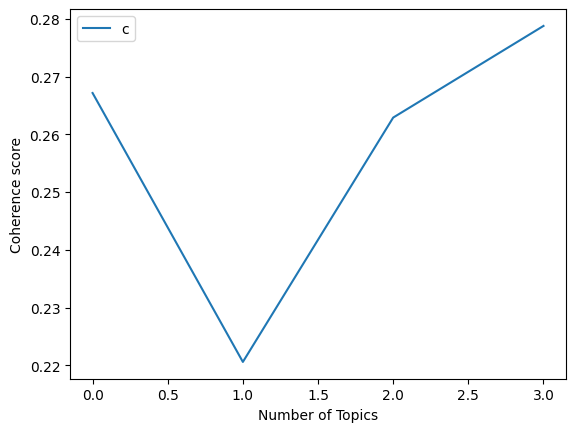

In [18]:
# Find the optimal number of topics
START = 10
LIMIT = 30
STEP = 5
topic_range = range(START, LIMIT, STEP)

coherence_values = []
model_list = []
for num_topics in topic_range:
    model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
    model_list.append(model)
    coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=train_df['caption_lemmatized'],
                                                                 dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

max_coherence_val = 0
optimal_model = None

# Print the coherence scores
for i, (m, cv) in enumerate(zip(topic_range, coherence_values)):
    if max_coherence_val < round(cv, 4):
        optimal_model = model_list[i]
        optimal_num_topics = m
        max_coherence_val = round(cv, 4)

    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

# plot coherence results
plt.plot(coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the Keyword in the 10 topics
for topic in optimal_model.print_topics():
    print(topic)

doc_lda = optimal_model[corpus]

(14, '0.049*"dog" + 0.040*"ball" + 0.036*"boy" + 0.022*"walk" + 0.022*"blue" + 0.022*"play" + 0.021*"puppy" + 0.018*"yellow" + 0.017*"run" + 0.014*"little"')
(24, '0.046*"dog" + 0.030*"white" + 0.027*"woman" + 0.023*"black" + 0.022*"jump" + 0.018*"man" + 0.017*"small" + 0.015*"stand" + 0.015*"ride" + 0.014*"snow"')
(23, '0.071*"slide" + 0.039*"girl" + 0.029*"child" + 0.026*"little" + 0.022*"purple" + 0.014*"water" + 0.014*"home" + 0.014*"bottom" + 0.013*"young" + 0.012*"woman"')
(21, '0.061*"girl" + 0.028*"sit" + 0.026*"woman" + 0.024*"man" + 0.021*"little" + 0.018*"people" + 0.017*"young" + 0.016*"boy" + 0.016*"walk" + 0.013*"blue"')
(4, '0.033*"man" + 0.031*"boy" + 0.030*"bike" + 0.026*"trick" + 0.023*"woman" + 0.022*"skateboard" + 0.017*"person" + 0.017*"skate" + 0.017*"jump" + 0.015*"hold"')
(11, '0.036*"child" + 0.025*"boy" + 0.025*"jump" + 0.024*"man" + 0.020*"sit" + 0.016*"hat" + 0.016*"girl" + 0.016*"people" + 0.016*"woman" + 0.015*"water"')
(1, '0.046*"sit" + 0.036*"water" + 0

In [20]:
print('Optimal Number of Topics :', optimal_num_topics)

# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=optimal_model, texts=train_caption_lemmatized,
                                                                  dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Optimal Number of Topics : 25

Perplexity:  -6.366787415440327

Coherence Score:  0.27877862971995704


In [21]:
def predictTopics(corpus):

    caption_topics_df = pd.DataFrame()
    print(type(corpus))
    print(corpus)
    # Get main topic in each document
    for i, row in enumerate(optimal_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = optimal_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                caption_topics_df = caption_topics_df._append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),
                                                             ignore_index=True)
            else:
                break

    caption_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    return caption_topics_df

In [22]:
df = predictTopics([id2word.doc2bow(text) for text in train_df['caption_lemmatized']])
train_df = pd.concat([train_df.reset_index(drop=True), df], axis=1)

#df = predictTopics([id2word.doc2bow(text) for text in valid_df['caption_lemmatized']])
#valid_df = pd.concat([valid_df.reset_index(drop=True), df], axis=1)

df = predictTopics([id2word.doc2bow(text) for text in test_df['caption_lemmatized']])
test_df = pd.concat([test_df.reset_index(drop=True), df], axis=1)

<class 'list'>
[[(0, 2), (1, 1), (2, 4), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 3), (11, 3), (12, 1), (13, 2), (14, 1), (15, 3), (16, 3)], [(7, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 2), (22, 3), (23, 4), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 3), (30, 2), (31, 4), (32, 1), (33, 1)], [(0, 3), (2, 3), (16, 2), (34, 1), (35, 1), (36, 4), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 4)], [(13, 2), (18, 3), (22, 1), (23, 3), (28, 2), (31, 1), (48, 2), (49, 1), (50, 2), (51, 4), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 3)], [(58, 1), (59, 4), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 5), (68, 3), (69, 1), (70, 2), (71, 1), (72, 2), (73, 2)], [(8, 1), (33, 1), (60, 4), (73, 1), (74, 1), (75, 4), (76, 3), (77, 1), (78, 3)], [(6, 1), (7, 1), (13, 3), (23, 4), (69, 1), (79, 1), (80, 1), (81, 3), (82, 1), (83, 1), (84, 2), (85, 2), (86, 1), (87, 1), (88, 1)], [(2, 5), (16, 

In [169]:
test_df

,image_id,caption,caption_lemmatized,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,flickr8k/Flicker8k_Dataset/1131932671_c8d17751b3.jpg,A boy is jumping on a bed . A boy jumped up from the green bed . A boy jumps from one bed to another . A small child is jumping on a bed . The boy in blue shorts is bouncing on the bed .,"[boy, jump, bed, boy, jump, green, bed, boy, jump, bed, small, child, jump, bed, boy, blue, short, bounce, bed]",20,0.6600,"boy, woman, man, girl, run, people, jump, young, play, wear"
1,flickr8k/Flicker8k_Dataset/1167669558_87a8a467d6.jpg,"A man in yellow grimaces . a man wearing a yellow shirt with a dramatic look on his face The man in the yellow t-shirt is pulling a large grin on his face . There is a man , wearing a yellow shirt , and grimacing . This man is smiling very big at the camera .","[man, yellow, grimace, man, wear, yellow, shirt, dramatic, look, face, man, yellow, tshirt, pull, large, grin, face, man, wear, yellow, shirt, grimace, man, smile, big, camera]",20,0.5532,"boy, woman, man, girl, run, people, jump, young, play, wear"
2,flickr8k/Flicker8k_Dataset/1174629344_a2e1a2bdbf.jpg,A crowd of people walk down a busy sidewalk . A group of different people are walking in all different directions in a city . A group of people walking a city street in warm weather . Busy intersection in the summer time in a city People in summer clothes are walking on the sidewalk of a large city .,"[crowd, people, walk, busy, sidewalk, group, different, people, walk, different, direction, city, group, people, walk, city, street, warm, weather, busy, intersection, summer, time, city, people, summer, clothe, walk, sidewalk, large, city]",15,0.5100,"man, walk, people, dog, woman, white, take, sidewalk, wear, snow"
3,flickr8k/Flicker8k_Dataset/1248940539_46d33ed487.jpg,"Three children are playing in sand near to the beach . Three children playing in sand at beach Three girls play in the sand . Three little blond girls , two in blue , one in pink , play on a sunny beach . Three young girls dance on the beach in the sand .","[child, play, sand, child, play, sand, beach, girl, play, sand, little, blond, girl, blue, pink, play, sunny, beach, young, girl, dance, beach, sand]",5,0.6786,"girl, wear, woman, man, stand, walk, water, play, young, boy"
4,flickr8k/Flicker8k_Dataset/1258913059_07c613f7ff.jpg,A couple of people sit outdoors at a table with an umbrella and talk . Three people are sitting at an outside picnic bench with an umbrella . Three people sit at an outdoor cafe . Three people sit at an outdoor table in front of a building painted like the Union Jack . Three people sit at a picnic table outside of a building painted like a union jack .,"[couple, people, sit, outdoors, table, umbrella, talk, people, sit, picnic, bench, umbrella, people, sit, outdoor, cafe, people, sit, outdoor, table, front, building, paint, union, people, sit, picnic, table, building, paint, union, jack]",7,0.3265,"man, woman, boy, sit, skateboard, hold, look, stand, trick, shirt"
...,...,...,...,...,...,...
95,flickr8k/Flicker8k_Dataset/544576742_283b65fa0d.jpg,A rock climber repels off a rocky wall . A woman climbing a rock cliff . A woman in jeans rock climbing . The woman is holding onto a huge rock and has red string around her . Woman goes rock climbing .,"[rock, climber, repel, woman, climb, rock, jean, rock, climb, woman, hold, huge, rock, red, string, woman, go, rock, climb]",18,0.5601,"man, dog, jump, play, girl, blue, red, boy, small, hold"
96,flickr8k/Flicker8k_Dataset/747921928_48eb02aab2.jpg,a boy holds two sparklers . A boy plays with sparklers at night . A child holds sparklers in the dark . A little boy holds fire sprinklers out in front of him . A small boy holding two fireworks sparklers .,"[boy, hold, sparkler, boy, play, sparkler, night, child, hold, sparkler, dark, little, boy, hold, fire, sprinkler, front, small, boy, hold, firework, sparkler]",1,0.5323,"sit, water, bench, girl, man, dog, people, child, boy, stand"
9

In [24]:
import os
import pickle

if not os.path.isfile("train_df.pkl"):
    with open("train_df.pkl",'wb') as file:
        pickle.dump(train_df, file)

In [25]:
print(train_df.values.tolist()[0])
#print(np.array(train_df.values.tolist()[0]).shape)

['flickr8k/Flicker8k_Dataset/1012212859_01547e3f17.jpg', 'A dog shakes its head near the shore , a red ball next to it . A white dog shakes on the edge of a beach with an orange ball . Dog with orange ball at feet , stands on shore shaking off water White dog playing with a red ball on the shore near the water . White dog with brown ears standing near water with head turned to one side .', ['dog', 'shake', 'head', 'shore', 'ball', 'next', 'white', 'dog', 'shake', 'edge', 'foot', 'stand', 'shore', 'shake', 'water', 'white', 'dog', 'play', 'red', 'ball', 'shore', 'water', 'white', 'dog', 'brown', 'ear', 'stand', 'water', 'head', 'turn', 'side'], 12, 0.7921000123023987, 'dog, brown, black, run, play, white, water, ball, mouth, snow']


In [133]:
image_shape = (224, 224, 3)
feature_extractor = tf.keras.applications.MobileNetV3Small(input_shape = image_shape, include_top = True)
#feature_extractor = tf.keras.applications.VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))
feature_extractor.trainable = False

In [156]:
output_model = tf.keras.layers.Dense(576, activation='tanh')(feature_extractor.layers[-1].output)
output_model = tf.keras.layers.Dropout(0.5)(output_model)
output_model = tf.keras.layers.Dense(256, activation='tanh')(output_model)
output_model = tf.keras.layers.Dropout(0.5)(output_model)
output_model = tf.keras.layers.Dense(optimal_num_topics, activation='softmax')(output_model)

feature_extractor = tf.keras.models.Model(inputs = feature_extractor.input, outputs = output_model)

feature_extractor.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["accuracy"])
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_2[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

In [157]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images_paths, labels, image_dimensions=(224, 224, 3), batch_size=64, shuffle=False):
        self.labels       = labels              # array of labels
        self.images_paths = images_paths        # array of image paths
        self.image_dim = image_dimensions
        self.batch_size   = batch_size          # batch size
        self.shuffle      = shuffle             # shuffle bool

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images_paths) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # selects indices of data for next batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # select data and load images
        labels = np.array([self.labels[k] for k in indexes])

        images = np.array([self.preprocessImageForVGG16(self.images_paths[k]) for k in indexes])

        return images, labels


    #customize function used for color convetion
    def preprocessImageForVGG16(self, filename):
        # load image
        image = tf.keras.preprocessing.image.load_img(filename, target_size=(self.image_dim[0], self.image_dim[1]))
        # convert the image pixels to a numpy array
        image = tf.keras.preprocessing.image.img_to_array(image)
        # prepare the image for the VGG model
        image = tf.keras.applications.vgg16.preprocess_input(image)

        return image

In [158]:
X_train = train_df['image_id'].values
Y_train = train_df['Dominant_Topic'].values
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=optimal_num_topics)

X_test = test_df['image_id'].values
Y_test = test_df['Dominant_Topic'].values
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=optimal_num_topics)


# prepare data generator
train_data = DataGenerator(X_train, Y_train, batch_size=50, shuffle=True)
valid_data = DataGenerator(X_test, Y_test, batch_size=50, shuffle=False)


In [159]:
history = feature_extractor.fit(train_data,
                    epochs=5,
                    validation_data=valid_data,
                    batch_size=8,
                    verbose=1)

Epoch 1/5
20/20 [==============================] - 26s 1s/step - loss: 2.8812 - accuracy: 0.1870 - val_loss: 2.7916 - val_accuracy: 0.1800
Epoch 2/5
20/20 [==============================] - 18s 863ms/step - loss: 2.7657 - accuracy: 0.2240 - val_loss: 2.6985 - val_accuracy: 0.2400
Epoch 3/5
20/20 [==============================] - 19s 928ms/step - loss: 2.7312 - accuracy: 0.2220 - val_loss: 2.6862 - val_accuracy: 0.2300
Epoch 4/5
20/20 [==============================] - 19s 922ms/step - loss: 2.7149 - accuracy: 0.2200 - val_loss: 2.6787 - val_accuracy: 0.2400
Epoch 5/5
20/20 [==============================] - 21s 1s/step - loss: 2.7079 - accuracy: 0.2270 - val_loss: 2.6759 - val_accuracy: 0.2100


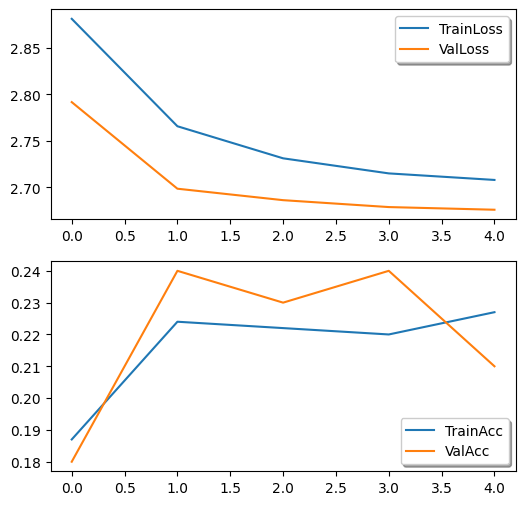

In [160]:
# plot training history
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(history.history['loss'], label="TrainLoss")
ax[0].plot(history.history['val_loss'], label="ValLoss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], label="TrainAcc")
ax[1].plot(history.history['val_accuracy'], label="ValAcc")
ax[1].legend(loc='best', shadow=True)
plt.show()

In [161]:
X_test = test_df['image_id'].values
Y_test = test_df['Dominant_Topic'].values
#print(Y_test)
Y_test = tf.keras.utils.to_categorical(Y_test, optimal_num_topics)

# prepare data generator
test_data = DataGenerator(X_test, Y_test, batch_size=1, shuffle=False)

# predict on data
pred_caption_topics_prob = feature_extractor.predict(test_data)
pred_caption_topics = np.argmax(pred_caption_topics_prob, axis=1)
print(pred_caption_topics)
results_df = pd.DataFrame({ 'image_id':X_test, 'pred_topics':pred_caption_topics })
results_df.head(100)

100/100 [==============================] - 4s 26ms/step
[ 5  5  5 22  5 12 12 12  5 12  5  5  5 12  5  5 12 12 22  5 12  5  5 22
  5 12 22 12 12  5  5  5 12 12  5  5  5 12  5 12  5 12  5 12 12 22  5 22
 12 12  5 12  5  5  5  5  5 22 22  5  5  5  5  5  5 22  5 22 22 22 12  5
 12  5 22 22  5 12  5  5 12  5  5 12 12 12  5 12  5  5 12 22 12  5 12 22
  5  5  5 12]


,image_id,pred_topics
0,flickr8k/Flicker8k_Dataset/1131932671_c8d17751b3.jpg,5
1,flickr8k/Flicker8k_Dataset/1167669558_87a8a467d6.jpg,5
2,flickr8k/Flicker8k_Dataset/1174629344_a2e1a2bdbf.jpg,5
3,flickr8k/Flicker8k_Dataset/1248940539_46d33ed487.jpg,22
4,flickr8k/Flicker8k_Dataset/1258913059_07c613f7ff.jpg,5
...,...,...
95,flickr8k/Flicker8k_Dataset/544576742_283b65fa0d.jpg,22
96,flickr8k/Flicker8k_Dataset/747921928_48eb02aab2.jpg,5
97,flickr8k/Flicker8k_Dataset/757332692_6866ae545c.jpg,5
98,flickr8k/Flicker8k_Dataset/872622575_ba1d3632cc.jpg,5


from matplotlib import pyplot as plt
_df_0['pred_topics'].plot(kind='hist', bins=20, title='pred_topics')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['pred_topics'].plot(kind='line', figsize=(8, 4), title='pred_topics')
plt.gca().spines[['top', 'right']].set_visible(False)

In [35]:
class DataGenerator1(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images_paths, labels, image_dimensions=(224, 224, 3), shuffle=False):
        self.labels = labels              # array of labels
        self.images_paths = images_paths  # array of image paths
        self.image_dim = image_dimensions
        self.shuffle = shuffle           # shuffle bool

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.images_paths)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data or single image'
        # select data and load images
        filename = self.images_paths[index]

        label = self.labels[index]

        image = self.preprocessImageForVGG16(filename)

        return image, label

    def preprocessImageForVGG16(self, filename):
        # load image
        image = tf.keras.utils.load_img(filename, target_size=(self.image_dim[0], self.image_dim[1]))
        # convert the image pixels to a numpy array
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = np.expand_dims(image, axis=0)
        # prepare the image for the VGG model
        image = tf.keras.applications.vgg16.preprocess_input(image)


        return image


In [140]:
class DataGenerator2(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images_paths, labels, image_dimensions=(224, 224, 3), shuffle=False):
        self.labels = labels              # array of labels
        self.images_paths = images_paths  # array of image paths
        self.image_dim = image_dimensions
        self.shuffle = shuffle           # shuffle bool

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.images_paths)

    def __getitem__(self, index):
        'Generate one batch of data or single image'
        print(index)
        # select data and load images
        filename = self.images_paths[index]
        label = self.labels[index]
        image = self.preprocessImageForVGG16(filename)
        print(type(image))
        print(type(label))
        data = image, label
        print(type(data))
        return data

    def preprocessImageForVGG16(self, filename):
        # load image
        image = tf.keras.utils.load_img(filename, target_size=(self.image_dim[0], self.image_dim[1]))
        # convert the image pixels to a numpy array
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = np.expand_dims(image, axis=0)
        # prepare the image for the VGG model
        image = tf.keras.applications.vgg16.preprocess_input(image)
        return image


In [173]:
#feature_extractor.load_weights('./content/topic_predictor_model.hdf5')
import cv2

X_test1 = df['image'].values #test_df['image_id'].values[:2]
print(X_test1)

Y_test1 = df['labels'].values #test_df['Dominant_Topic'].values[:2]
print(Y_test1)
Y_test1 = tf.keras.utils.to_categorical(Y_test1, optimal_num_topics)

# prepare data generator
test_data1 = DataGenerator2(X_test1, Y_test1, shuffle=False)

# predict on data
pred_caption_topics_prob1 = feature_extractor.predict(test_data1)
pred_caption_topics1 = np.argmax(pred_caption_topics_prob1, axis=1)
print(pred_caption_topics1)
results_df1 = pd.DataFrame({ 'image_id':X_test1, 'pred_topics':pred_caption_topics1 })
results_df1.head()

['flickr8k/Flicker8k_Dataset/544576742_283b65fa0d.jpg']
[18]
0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>
1/1 [==============================] - 0s 79ms/step
[22]


,image_id,pred_topics
0,flickr8k/Flicker8k_Dataset/544576742_283b65fa0d.jpg,22


In [179]:
print(np.array(results_df1['pred_topics'].values[0]))
#test_df['Dominant_Topic'].values[0]

22
